In [30]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('../datasets/teen_phone_addiction_dataset.csv')
data_series = df['Daily_Usage_Hours']

Рассчитайте характеристики:

Среднее
Дисперсия
Мода
Медиана
Квантили 
уровня 
0.25, 0.5, 0.75
Эксцесс
Ассиметрия
Интерквартильный размах

In [32]:
print("Среднее значение", data_series.mean())
print("Дисперсия", data_series.var())
print("Мода", data_series.mode()[0] if not data_series.mode().empty else np.nan)
print("Медиана", data_series.median())
quantilies = data_series.quantile([0.25, 0.5, 0.75])
print("Квантили", quantilies.values)
print("Эксцесс",stats.kurtosis(data_series, bias=False))
print("Ассиметрия", stats.skew(data_series, bias=False))
print("Интерквартильный размах", quantilies[0.75] - quantilies[0.25])

Среднее значение 5.020666666666667
Дисперсия 3.827895520729132
Мода 4.4
Медиана 5.0
Квантили [3.7 5.  6.4]
Эксцесс -0.12081610863833259
Ассиметрия 0.016205396823206885
Интерквартильный размах 2.7


Среднее = 5.02 и медиана = 5.0 → они почти совпадают, значит распределение близко к симметричному.

Ассиметрия ≈ 0.016 → очень маленькое значение, распределение действительно симметрично.

Мода = 4.4, медиана = 5.0, среднее = 5.02 → значения близки, существенного перекоса нет.

Эксцесс = –0.12 → близко к 0, распределение похоже на нормальное, но чуть более «приплюснутое» (менее острое).

Квантили [3.7; 5.0; 6.4] и интерквартильный размах = 2.7 → данные распределены достаточно компактно вокруг центра.

Дисперсия = 3.83 → умеренное рассеяние относительно среднего.

Гистограмма и эмперичская функция распределения


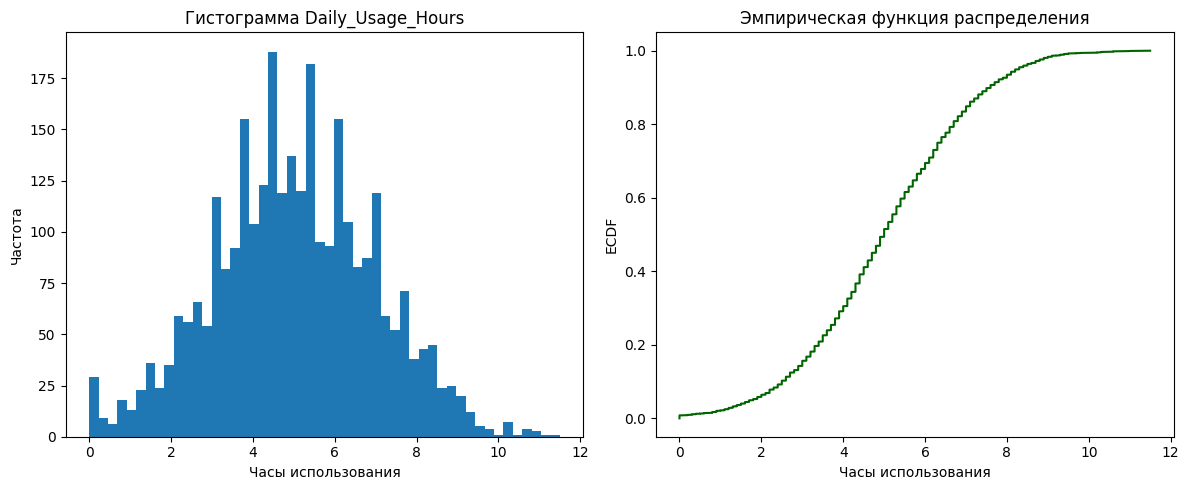

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(data_series, bins = 50)
plt.title('Гистограмма Daily_Usage_Hours')
plt.xlabel('Часы использования')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sorted_data = np.sort(data_series)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
plt.plot(sorted_data, y, color='darkgreen')
plt.title('Эмпирическая функция распределения')
plt.xlabel('Часы использования')
plt.ylabel('ECDF')

plt.tight_layout()
plt.show()

Критерий Хи квадрат

In [34]:
mean = data_series.mean()
std = np.sqrt(data_series.var())
n = len(data_series)

In [35]:
#Разбиваем данные на интервалы
bins = 10
hist, bin_edges = np.histogram(data_series, bins = bins, density=False)
observed = hist

In [36]:
#Вычисляем ожидаемые частоты
expected = []
for i in range(len(bin_edges) - 1):
    left = bin_edges[i]
    right = bin_edges[i + 1]
    prob = stats.norm.cdf(right, mean, std) - stats.norm.cdf(left, mean, std)
    expected.append(prob * n)


expected = np.array(expected)

In [37]:
if any(e < 5 for e in expected):
    print("Предупреждение: некоторые ожидаемые частоты < 5, попробуйте увеличить bins или объединить интервалы")

In [38]:
#Статистика хи-квадрат
chi_square_stat = np.sum((observed - expected) ** 2 / expected)
df_chi = len(observed) - 1 - 2 #Степени свободы
critical_value = stats.chi2.ppf(1 - 0.05, df_chi) #критическое значение

In [39]:
print("Критерий хи-квадрат:")
print(f"Статистика хи-квадрат: {chi_square_stat:.2f}")
print(f"Критическое значение (alpha=0.05, df={df_chi}): {critical_value:.2f}")
if chi_square_stat > critical_value:
    print("Отвергаем гипотезу о нормальности (данные не нормальны)")
else:
    print("Не отвергаем гипотезу о нормальности")

Критерий хи-квадрат:
Статистика хи-квадрат: 16.62
Критическое значение (alpha=0.05, df=7): 14.07
Отвергаем гипотезу о нормальности (данные не нормальны)


Q-Q Plot

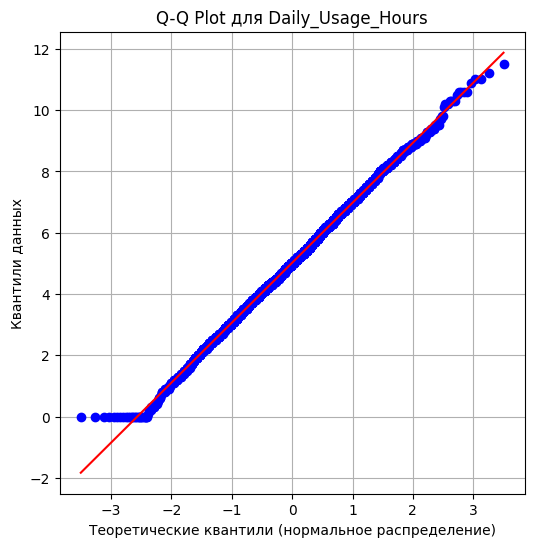

In [40]:
from scipy.stats import probplot

plt.figure(figsize=(6, 6))  # Размер графика
probplot(data_series, dist='norm', plot=plt)
plt.title('Q-Q Plot для Daily_Usage_Hours')
plt.xlabel('Теоретические квантили (нормальное распределение)')
plt.ylabel('Квантили данных')
plt.grid(True)
plt.show()

In [41]:
data_series.isna().sum()

np.int64(0)

Приведение данных к норм распределение через удаление выбросов

In [42]:
Q1 = data_series.quantile(0.25)
Q3 = data_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(0, Q1 - 1.5 * IQR) 
upper_bound = Q3 + 1.5 * IQR 

In [43]:
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Количество выбросов: {((data_series < lower_bound) | (data_series > upper_bound)).sum()} из {len(data_series)}")

Q1: 3.70, Q3: 6.40, IQR: 2.70
Границы выбросов: [0.00, 10.45]
Количество выбросов: 10 из 3000


In [44]:
filtered_series = data_series[(data_series >= lower_bound) & (data_series <= upper_bound)]

In [45]:
data_stand = (filtered_series - mean) / std

Характеристики после стандартизирования данных

In [46]:
print("Среднее значение", data_stand.mean())
print("Дисперсия", data_stand.var())
print("Мода", data_stand.mode()[0] if not data_stand.mode().empty else np.nan)
print("Медиана", data_stand.median())
quantilies_stand = data_stand.quantile([0.25, 0.5, 0.75])
print("Квантили", quantilies.values)
print("Эксцесс",stats.kurtosis(data_stand, bias=False))
print("Ассиметрия", stats.skew(data_stand, bias=False))
print("Интерквартильный размах", quantilies_stand[0.75] - quantilies_stand[0.25])

Среднее значение -0.009964778827300331
Дисперсия 0.9734622476872458
Мода -0.3172330189131645
Медиана -0.010563075817731778
Квантили [3.7 5.  6.4]
Эксцесс -0.23746777628397764
Ассиметрия -0.04574018031644596
Интерквартильный размах 1.3289030867468759


Выводы:
Распределение данных очень близко к стандартному нормальному 𝑁(0,1):

центр около нуля,

дисперсия единица,

симметрия и эксцесс практически совпадают с нормальным.

Отклонения минимальны, можно считать данные нормально распределёнными.

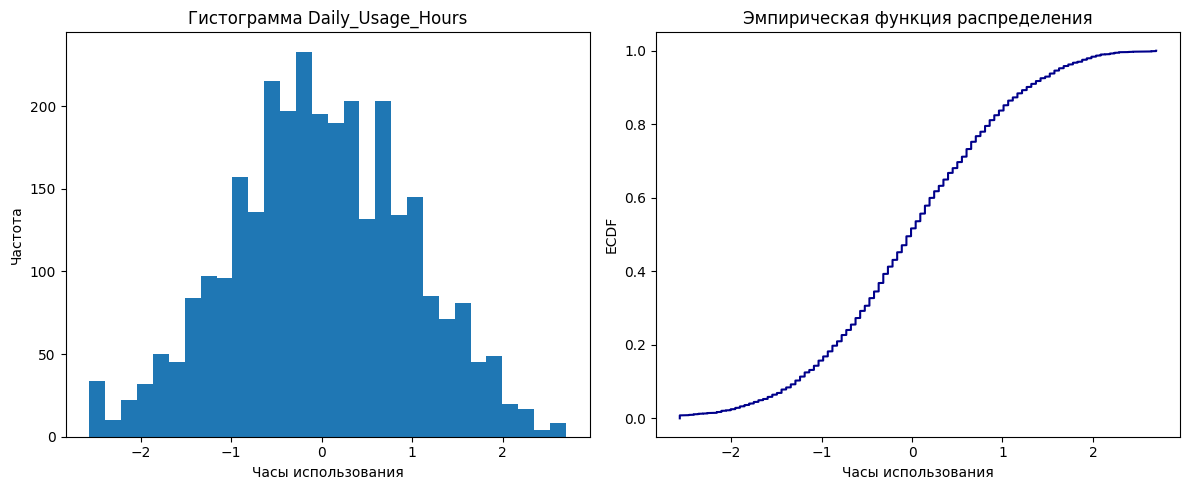

In [47]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(data_stand, bins = 30)
plt.title('Гистограмма Daily_Usage_Hours')
plt.xlabel('Часы использования')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sorted_data = np.sort(data_stand)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
plt.plot(sorted_data, y, color='darkblue')
plt.title('Эмпирическая функция распределения')
plt.xlabel('Часы использования')
plt.ylabel('ECDF')

plt.tight_layout()
plt.show()

In [48]:
mean = data_stand.mean()
std = np.sqrt(data_stand.var())
n = len(data_stand)

In [49]:
#Разбиваем данные на интервалы
bins = 10
hist, bin_edges = np.histogram(data_stand, bins = bins, density=False)
observed = hist #наблюдаемые частоты

In [50]:
#Вычисляем ожидаемые частоты
expected = []
for i in range(len(bin_edges) - 1):
    left = bin_edges[i]
    right = bin_edges[i + 1]
    prob = stats.norm.cdf(right, mean, std) - stats.norm.cdf(left, mean, std)
    expected.append(prob * n)


expected = np.array(expected)

In [51]:
if any(e < 5 for e in expected):
    print("Предупреждение: некоторые ожидаемые частоты < 5, попробуйте увеличить bins или объединить интервалы")

In [52]:
#Статистика хи-квадрат
chi_square_stat = np.sum((observed - expected) ** 2 / expected)
df_chi = len(observed) - 1 - 2 #Степени свободы
critical_value = stats.chi2.ppf(1 - 0.05, df_chi) #критическое значение

In [53]:
print("Критерий хи-квадрат:")
print(f"Статистика хи-квадрат: {chi_square_stat:.2f}")
print(f"Критическое значение (alpha=0.05, df={df_chi}): {critical_value:.2f}")
if chi_square_stat > critical_value:
    print("Отвергаем гипотезу о нормальности (данные не нормальны)")
else:
    print("Не отвергаем гипотезу о нормальности")

Критерий хи-квадрат:
Статистика хи-квадрат: 27.73
Критическое значение (alpha=0.05, df=7): 14.07
Отвергаем гипотезу о нормальности (данные не нормальны)


In [54]:
grouped = df.groupby('School_Grade')['Daily_Usage_Hours']
stats_value = grouped.agg(['mean','var']).round(2)
print('Среднее и дисперсия по группам:')
print(stats_value)


Среднее и дисперсия по группам:
              mean   var
School_Grade            
10th          4.98  3.81
11th          5.06  3.64
12th          4.94  3.74
7th           5.08  3.88
8th           5.07  4.01
9th           5.01  3.91


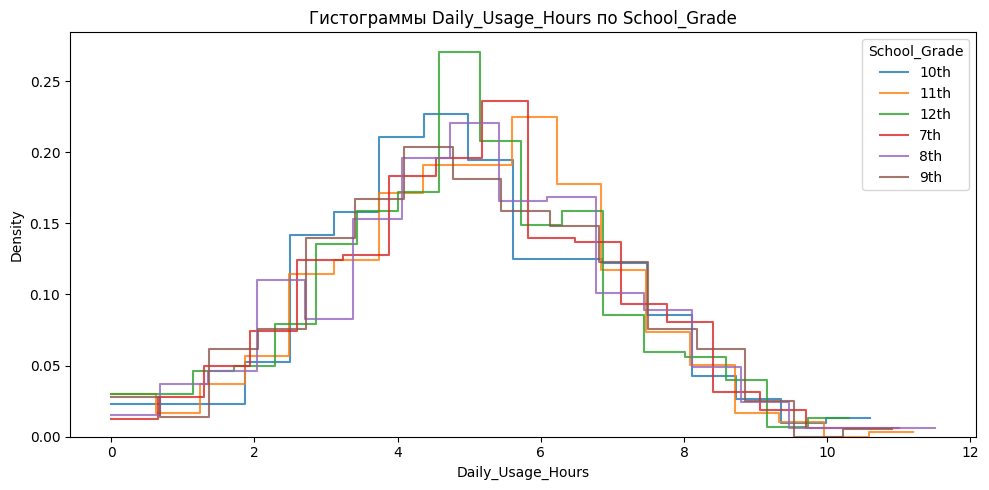

In [55]:
import seaborn as sns

unique_grades = sorted(df['School_Grade'].dropna().unique())
colors = sns.color_palette('tab10', n_colors=len(unique_grades))

plt.figure(figsize=(10, 5))
for c, g in zip(colors, unique_grades):
    vals = df.loc[df['School_Grade'] == g, 'Daily_Usage_Hours'].dropna().astype(float)
    sns.histplot(vals, bins='auto', stat='density', kde=False, element='step', fill=False, color=c, label=str(g), alpha=0.8)
plt.title(f'Гистограммы Daily_Usage_Hours по School_Grade')
plt.xlabel('Daily_Usage_Hours')
plt.legend(title='School_Grade')
plt.tight_layout(); plt.show()
